In [1]:
import numpy as np
import pandas as pd
from datetime import date
import math
import matplotlib.pyplot as plt

# Initial Analysis

In [2]:
AUM = 10000000
annual_rtn = 0.05
year = 0
performance_pct = 0.15
management_pct = 0.003
hurdle_rate = -1
compoundFreq = "annual"
ini_day = date.today()

In [3]:
## convert frequency into meaningful period
def convertFreq(freq):
    ## default is annual
    if freq == "annual":
        return 1
    elif freq == "semi-annual":
        return 2
    elif freq == "quarterly":
        return 4
    elif freq == "monthly":
        return 12
    elif freq == "daily":
        return 365
    else:
        return 1
# ## Consider high-water mark, Investors do not need to pay 
# def totalFees(aum, annual_rtn, performance, management):
#     return aum*management+aum*annual_rtn*performance
# # totalFees(AUM, annual_rtn, performance, management)

DataFrame - Date, AUM(Investor's investment amount), performance_fee, management_fee, pct_return (assumption or real market data), high_water_mark_price, hurdle_price

A **high-water mark** is the highest value that an investment fund or account has ever reached.
If a hedge fund sets a 5% **hurdle rate**, for example, it will only collect incentive fees during periods when returns are higher than this amount.

Fee model optimization: Analysis of hedge funds charging structure on investors returns

Market Condition Simulator: 
1. sustained_scenario(provide percentage and period. )
3. random_market (provides random market condition)
5. client_customized. (provide a csv file of period return, file_location)
6. real_simulation. (provide ticker, start_date, end_date, frequency)

In [62]:
class MarketCond(object):
    def __init__(self, result):
        self.result = result

    @classmethod
    def sustained_scenario(cls, pct, year):
        """
        :param pct: annual return percentage
        :param year: number of years of simulation (must be integer)
        :return:
        """
        x = [pct] * year
        return pd.Series(x)

    @classmethod
    def random_market(cls, period):
        mu, sigma = 0, 0.5
        s = np.random.normal(mu, sigma, period)
        return pd.Series(s)

    @classmethod
    def client_customized(cls, file_location):
        pct = pd.read_csv(file_location, header=None)
        return pct[0]

class FeeGenerator(object):
    def __init__(self, aum, market_cond, perf_pct=0, mana_pct=0, market_freq="annual",
                 fee_freq="annual", high_water=False, hurdle=-1,
                 entry=0, exit=0, admin=0):
        """
        :param aum: Asset under management.
        :param perf_pct:
        :param mana_pct:
        :param market_cond: A pandas series to capture all market condition during the period of simulation.
        :param market_freq: frequency of recorded percentage of return, support "annual", "semi-annual",
                               "quarterly", "monthly", "daily".
        :param fee_freq: Period to take fees, support "annual", "semi-annual",
                            "quarterly", "monthly".
        :param high_water: Whether to record the high water mark or not.
        :param hurdle: hurdle rate. Default to -1, meaning no hurdle rate.
        :param entry: A percentage that hedge funds will take once the client invests.
        :param exit:
        :param admin:
        """
        self.aum = aum
        self.perf_pct = perf_pct
        self.mana_pct = mana_pct
        self.market_freq = self.change_freq(market_freq)
        self.fee_freq = self.change_freq(fee_freq)
        self.market_cond = self.calibrate_condition(market_cond, self.fee_freq, self.market_freq)
        self.high_water = high_water
        self.hurdle = hurdle/(self.fee_freq // self.market_freq) if self.fee_freq>self.market_freq else hurdle/(self.market_freq // self.fee_freq)
        self.entry_fee = entry
        self.exit = exit
        self.admin = admin

        self.fee = self.generate_fee()

    @staticmethod
    def calibrate_condition(market_cond, fee, market):
        """
        Calculate the final market condition Series.

        :param market_cond: A pandas series to capture all market condition during the period of simulation.
        :param fee:
        :param market:
        :return:
        """
#         print(market_cond)
        pct = []
        if fee == market:
            pct = market_cond.to_numpy()
        elif fee < market:
            period = market / fee
            pct = market_cond.apply(lambda x: 1+x).groupby(market_cond.index // period).prod().to_numpy()
        else:
#             print((1+np.repeat(market_cond.to_list(), (fee//market)))**(1/(fee//market)))
#             pct = (1+np.repeat(market_cond.to_list(), (fee//market)))**(1/(fee//market))-1
            pct = np.repeat(market_cond.to_list(), (fee / market)) / (fee / market)
        d = np.insert(pct, 0, 0)
        return pd.Series(data=d)

    @staticmethod
    def change_freq(freq):
        if freq == "annual":
            return 1
        elif freq == "semi-annual":
            return 2
        elif freq == "quarterly":
            return 4
        elif freq == "monthly":
            return 12
        elif freq == "daily":
            # Only counts for trading days.
            return 252
        else:
            print("Unrecognized input. We will use the default annual frequency. ")
            return 1

    def generate_fee(self):
        length = len(self.market_cond)
        arr = np.array([0]*length)
        d = {'AUM': arr, 'performance_fee': arr,
             'management_fee': arr, 'other_fee': arr, 'pct_return': self.market_cond,
             'high_water_mark_price': arr, 'hurdle_price': arr}
        fee_pd = pd.DataFrame(data=d)

        # Initialize fee model
        fee_pd.iloc[0] = [self.aum, 0.0, 0.0, self.entry_fee, 0.0,
                          self.aum, self.aum*(1+self.hurdle)]
        if not self.high_water:
            fee_pd.drop(columns=['high_water_mark_price'], inplace=True)
        if self.hurdle <= 0:
            fee_pd.drop(columns=['hurdle_price'], inplace=True)

        for i in range(1, length):
            original_aum = fee_pd.iloc[i-1][0]*(1+fee_pd.iloc[i][4])
            # Michals
#           fee_pd.iat[i, 2] = fee_pd.iloc[i-1][0]*self.mana_pct/self.fee_freq
            if self.high_water:
                fee_pd.iat[i, 5] = max(fee_pd.iat[i-1, 5], original_aum)
            if self.hurdle > 0:
                fee_pd.iat[i, 6] = fee_pd.iloc[i-1][0]*(1+self.hurdle)
            fee_pd.iat[i, 2] = original_aum*self.mana_pct/self.fee_freq
            if fee_pd.iat[i, 4] <= 0 or (('high_water_mark_price' in fee_pd) and fee_pd.iat[i, 5] > original_aum) or (('hurdle_price' in fee_pd) and fee_pd.iat[i, 6] > original_aum):
                fee_pd.iat[i, 1] = 0
            else:
                fee_pd.iat[i, 1] = fee_pd.iat[i, 4]*fee_pd.iloc[i-1][0]*self.perf_pct
            fee_pd.iat[i, 0] = original_aum - fee_pd.iat[i, 1] - fee_pd.iat[i, 2] - fee_pd.iat[i, 3]
        return fee_pd

In [75]:
market_condition = MarketCond.sustained_scenario(0.1, 25)
FeeGenerator(1000000, market_condition, perf_pct=0.2, mana_pct=0.02, market_freq="annual", fee_freq="annual", high_water=True, hurdle=0.09).fee

,AUM,performance_fee,management_fee,other_fee,pct_return,high_water_mark_price,hurdle_price
0,1000000,0.00,0.000,0,0.0,1000000,1090000.00
1,1058000,20000.00,22000.000,0,0.1,1100000,1090000.00
2,1119364,21160.00,23276.000,0,0.1,1163800,1153220.00
3,1184287,22387.28,24626.008,0,0.1,1231300,1220106.76
4,1252975,23685.74,26054.314,0,0.1,1302715,1290872.83
5,1325647,25059.50,27565.450,0,0.1,1378272,1365742.75
6,1402534,26512.94,29164.234,0,0.1,1458211,1444955.23
7,1483880,28050.68,30855.748,0,0.1,1542787,1528762.06
8,1569945,29677.60,32645.360,0,0.1,1632268,1617429.20
9,1661001,31398.90,34538.790,0,0.1,1726939,1711240.05


In [72]:
print("Annual Fee In Total:")
result1 = FeeGenerator(1000000, market_condition, perf_pct=0.2, mana_pct=0.02, market_freq="annual", fee_freq="annual", high_water=True, hurdle=0.01).fee
print(result1.management_fee.sum() + result1.performance_fee.sum())
print("Final Annual AUM:")
print(result1.AUM.tail(1).values[0])
print("Semi-Annual Fee In Total:")
result2 = FeeGenerator(1000000, market_condition, perf_pct=0.2, mana_pct=0.02, market_freq="annual", fee_freq="semi-annual", high_water=True, hurdle=0.01).fee
print(result2.management_fee.sum() + result2.performance_fee.sum())
print("Final Semi-Annual AUM:")
print(result2.AUM.tail(1).values[0])
print("monthly Fee In Total:")
result3 = FeeGenerator(1000000, market_condition, perf_pct=0.2, mana_pct=0.02, market_freq="annual", fee_freq="monthly", high_water=True, hurdle=0.01).fee
print(result3.management_fee.sum() + result3.performance_fee.sum())
print("Final monthly AUM:")
print(result3.AUM.tail(1).values[0])

Annual Fee In Total:
235814.29200000002
Final Annual AUM:
1325647
Semi-Annual Fee In Total:
234468.87300000002
Final Semi-Annual AUM:
1337403
monthly Fee In Total:
233433.07530555554
Final monthly AUM:
1347702


757339


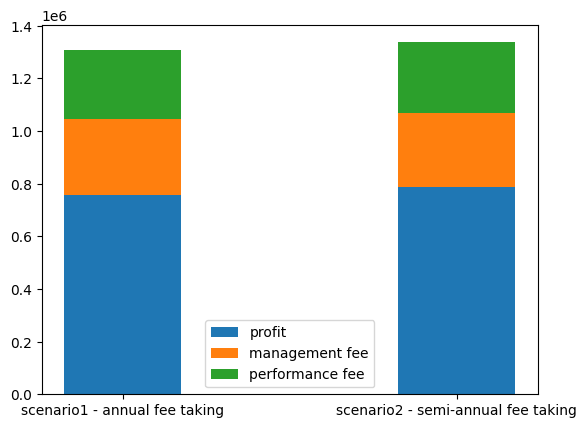

In [58]:
# Visualize
print(result1.AUM.tail(1).values[0]-result1.AUM.head(1).values[0])
gains = [result1.AUM.tail(1).values[0]-result1.AUM.head(1).values[0], result2.AUM.tail(1).values[0]-result2.AUM.head(1).values[0]]
management = [result1.management_fee.sum(), result2.management_fee.sum()]
prof = [result1.performance_fee.sum(), result2.performance_fee.sum()]
width = 0.35
labels = ['scenario1 - annual fee taking', 'scenario2 - semi-annual fee taking']
fig, ax = plt.subplots()
ax.bar(labels, gains, width, label='profit')
ax.bar(labels, management, width, bottom=np.array(gains),
       label='management fee')
ax.bar(labels, prof, width, bottom=np.array(gains)+np.array(management),
       label='performance fee')
ax.legend()
plt.show()

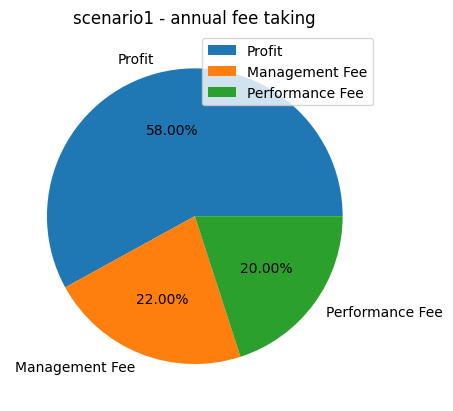

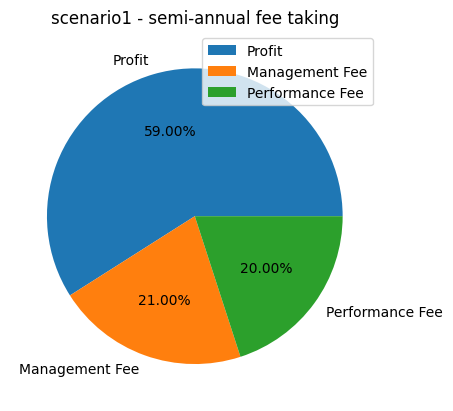

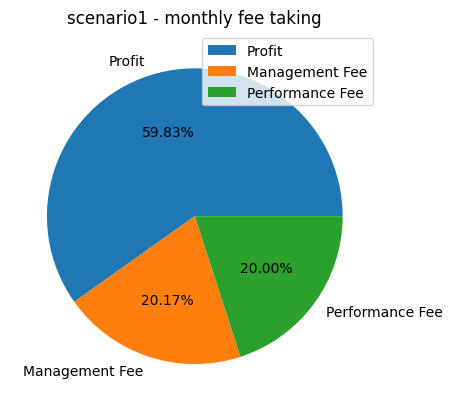

In [73]:
def piechart(result1, title_name):
    fig, ax = plt.subplots()
    ax.pie([result1.AUM.tail(1).values[0]-result1.AUM.head(1).values[0], result1.management_fee.sum(), result1.performance_fee.sum()], labels = ['Profit', 'Management Fee', 'Performance Fee'],autopct='%1.2f%%')
    ax.legend()
    ax.set_title(title_name)
    plt.show()
piechart(result1, "scenario1 - annual fee taking")
piechart(result2, "scenario1 - semi-annual fee taking")
piechart(result3, "scenario1 - monthly fee taking")

In [144]:
market_condition1 = MarketCond.sustained_scenario(0, 5)
FeeGenerator(1000000, 0.2, 0.02, market_condition1, market_freq="annual", fee_freq="semi-annual").fee

,AUM,performance_fee,management_fee,other_fee,pct_return
0,1000000,0.0,0.00,0,0.0
1,990000,0.0,10000.00,0,0.0
2,980100,0.0,9900.00,0,0.0
3,970299,0.0,9801.00,0,0.0
4,960596,0.0,9702.99,0,0.0
5,950990,0.0,9605.96,0,0.0
6,941480,0.0,9509.90,0,0.0
7,932065,0.0,9414.80,0,0.0
8,922744,0.0,9320.65,0,0.0
9,913516,0.0,9227.44,0,0.0


In [7]:
market_condition2 = MarketCond.client_customized('customized_cond.csv')
market_condition2
FeeGenerator(1000000, 0.2, 0.02, market_condition2, market_freq="annual", fee_freq="annual", high_water=True).fee

,AUM,performance_fee,management_fee,other_fee,pct_return,high_water_mark_price
0,1000000,0.0,0.0000,0,0.00,1000000
1,1058000,20000.0,22000.0000,0,0.10,1100000
2,943524,0.0,19255.6000,0,-0.09,1100000
3,1017118,0.0,20757.5280,0,0.10,1100000
4,907065,0.0,18511.5476,0,-0.09,1100000
5,977816,0.0,19955.4300,0,0.10,1100000
6,872016,0.0,17796.2512,0,-0.09,1100000
7,940033,0.0,19184.3520,0,0.10,1100000
8,838321,0.0,17108.6006,0,-0.09,1100000
9,903710,0.0,18443.0620,0,0.10,1100000


In [192]:
market_condition3 = MarketCond.random_market(5)
FeeGenerator(1000000, 0.2, 0.02, market_condition3, market_freq="annual", fee_freq="annual", high_water=True).fee

,AUM,performance_fee,management_fee,other_fee,pct_return,high_water_mark_price
0,1000000,0.000000,0.000000,0,0.000000,1000000
1,1170310,48797.610380,24879.761038,0,0.243988,1170310
2,1058532,0.000000,21602.712999,0,-0.077052,1170310
3,1075469,9771.199705,22147.759970,0,0.046154,1170310
4,1139080,21825.813460,23691.961346,0,0.101471,1170310
5,1059918,0.000000,21630.983857,0,-0.050506,1170310


In [14]:
MarketCond.sustained_scenario(0.1, 25)

0     0.1
1     0.1
2     0.1
3     0.1
4     0.1
5     0.1
6     0.1
7     0.1
8     0.1
9     0.1
10    0.1
11    0.1
12    0.1
13    0.1
14    0.1
15    0.1
16    0.1
17    0.1
18    0.1
19    0.1
20    0.1
21    0.1
22    0.1
23    0.1
24    0.1
dtype: float64